<h1 align="center">Segmentation: Region Growing</h1>

In this notebook we use one of the simplest segmentation approaches, region growing. We illustrate 
the use of three variants of this family of algorithms. The common theme for all algorithms is that a voxel's neighbor is considered to be in the same class if its intensities are similar to the current voxel. The definition of similar is what varies:

* <b>ConnectedThreshold</b>: The neighboring voxel's intensity is within explicitly specified thresholds.
* <b>ConfidenceConnected</b>: The neighboring voxel's intensity is within the implicitly specified bounds $\mu\pm c\sigma$, where $\mu$ is the mean intensity of the seed points, $\sigma$ their standard deviation and $c$ a user specified constant.
* <b>VectorConfidenceConnected</b>: A generalization of the previous approach to vector valued images, for instance multi-spectral images or multi-parametric MRI. The neighboring voxel's intensity vector is within the implicitly specified bounds using the Mahalanobis distance $\sqrt{(\mathbf{x}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{x}-\mathbf{\mu})}<c$, where $\mathbf{\mu}$ is the mean of the vectors at the seed points, $\Sigma$ is the covariance matrix and $c$ is a user specified constant.

We will illustrate the usage of these three filters using a cranial MRI scan (T1 and T2) and attempt to segment one of the ventricles.

In [6]:
%matplotlib notebook
import SimpleITK as sitk
import gui

# Using an external viewer (ITK-SNAP or 3D Slicer) we identified a visually appealing window-level setting
WINDOW_LEVEL = (400,400) # (Window Level,Window Range)

## Read Data and Select Seed Point(s)

We first load a T1 MRI brain scan and select our seed point(s). If you are unfamiliar with the anatomy you can use the preselected seed point specified below, just uncomment the line.

input shape: (35, 512, 512)


<IPython.core.display.Javascript object>


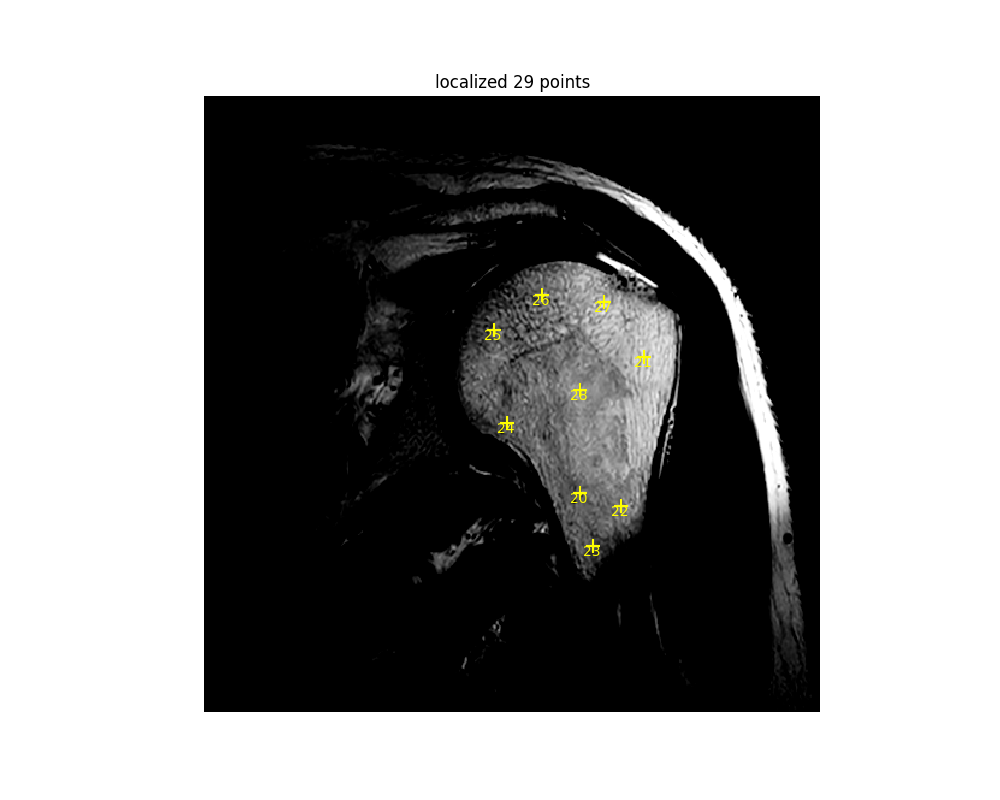

In [17]:
image = sitk.ReadImage('data/1_image.nii.gz')
print('input shape:', sitk.GetArrayFromImage(image).shape)
# Rescale the intensities and map them to [0,255], these are the default values for the output
# We will use this image to display the results of segmentation
image_uint8 = sitk.Cast(sitk.IntensityWindowing(image,
                                                windowMinimum=WINDOW_LEVEL[1]-WINDOW_LEVEL[0]/2.0, 
                                                windowMaximum=WINDOW_LEVEL[1]+WINDOW_LEVEL[0]/2.0), 
                                                sitk.sitkUInt8)

point_acquisition_interface = gui.PointDataAquisition(image, window_level=WINDOW_LEVEL)

In [28]:
initial_seed_point_indexes = point_acquisition_interface.get_point_indexes()
print(initial_seed_point_indexes, 'total:',len(initial_seed_point_indexes))

[(297, 208, 17), (252, 201, 18), (260, 234, 19), (346, 207, 19), (303, 183, 19), (314, 269, 19), (334, 264, 18), (358, 194, 18), (302, 251, 18), (328, 297, 18), (255, 255, 18), (272, 186, 18), (322, 300, 19), (362, 232, 19), (272, 221, 19), (314, 223, 19), (240, 198, 19), (277, 160, 19), (255, 161, 19), (368, 195, 19), (312, 329, 22), (365, 216, 22), (346, 340, 22), (323, 373, 22), (251, 271, 22), (240, 194, 22), (280, 165, 22), (332, 171, 22), (312, 244, 22)] total: 29


## ConnectedThreshold

We start by using explicitly specified thresholds, you should modify these (lower/upper) to see the effects on the 
resulting segmentation.

<IPython.core.display.Javascript object>


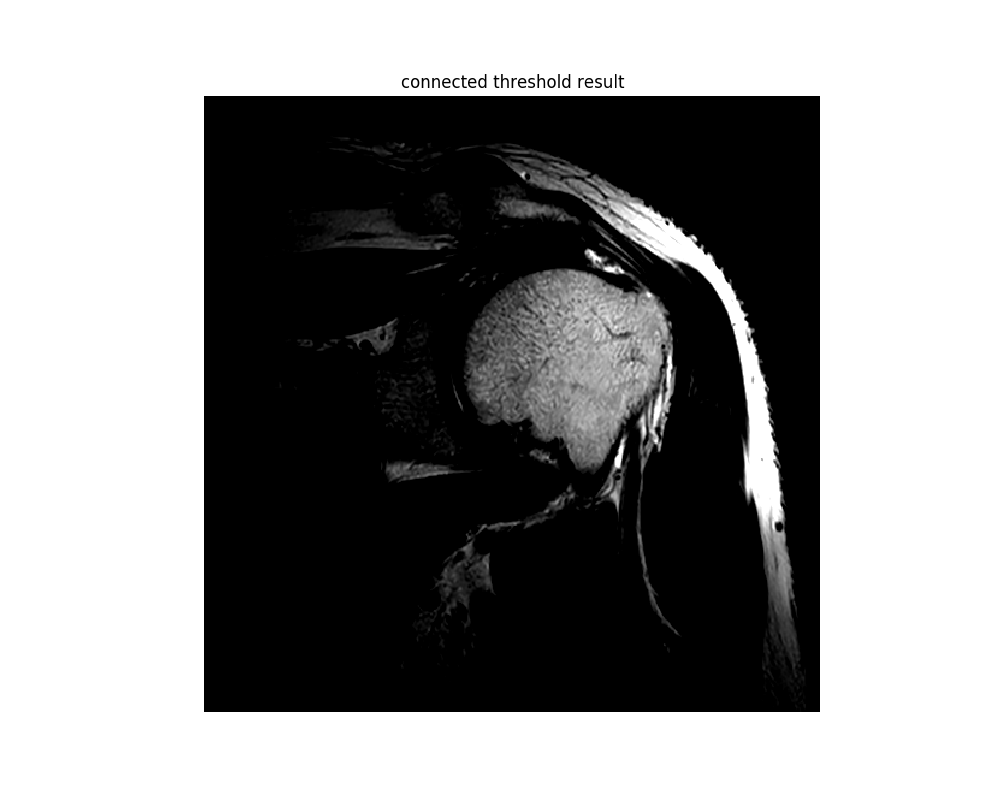

Box(children=(IntSlider(value=17, description='image slice:', max=34),))

In [29]:
threshold_lower=100
threshold_upper=200

seg_explicit_thresholds = sitk.ConnectedThreshold(image, seedList=initial_seed_point_indexes, lower=threshold_lower, upper=threshold_upper)
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(image_uint8, seg_explicit_thresholds)], title_list = ['connected threshold result'])

## ConfidenceConnected

This region growing algorithm allows the user to implicitly specify the threshold bounds based on the statistics estimated from the seed points, $\mu\pm c\sigma$. This algorithm has some flexibility which you should familiarize yourself with:
* The "multiplier" parameter is the constant $c$ from the formula above. 
* You can specify a region around each seed point "initialNeighborhoodRadius" from which the statistics are estimated, see what happens when you set it to zero.
* The "numberOfIterations" allows you to rerun the algorithm. In the first run the bounds are defined by the seed voxels you specified, in the following iterations $\mu$ and $\sigma$ are estimated from the segmented points and the region growing is updated accordingly.

<IPython.core.display.Javascript object>


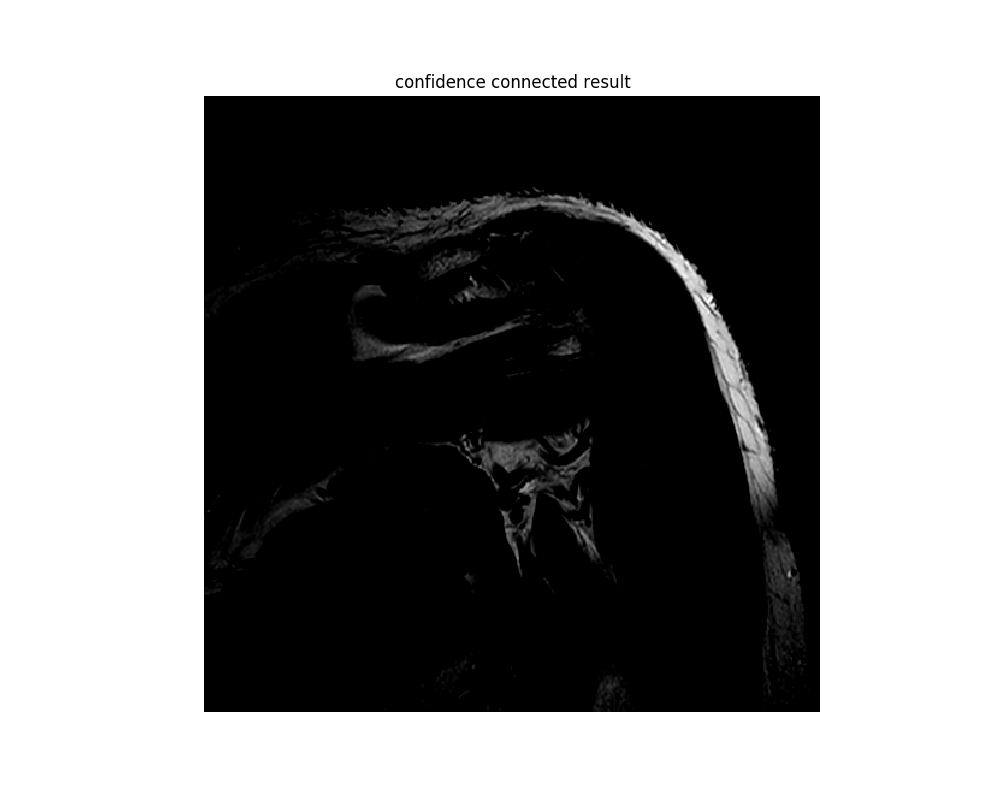

Box(children=(IntSlider(value=17, description='image slice:', max=34),))

In [27]:
seg_implicit_thresholds = sitk.ConfidenceConnected(image, seedList=initial_seed_point_indexes,
                                                   numberOfIterations=0,
                                                   multiplier=1,
                                                   initialNeighborhoodRadius=1,
                                                   replaceValue=1)

gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(image_uint8, seg_implicit_thresholds)],                   
                      title_list = ['confidence connected result'])

## VectorConfidenceConnected

We first load a T2 image from the same person and combine it with the T1 image to create a vector image. This region growing algorithm is similar to the previous one, ConfidenceConnected, and allows the user to implicitly specify the threshold bounds based on the statistics estimated from the seed points. The main difference is that in this case we are using the Mahalanobis and not the intensity difference.

In [31]:
image2 = sitk.ReadImage('data/1_image.nii.gz')
image_multi = sitk.Compose(image, image2)

<IPython.core.display.Javascript object>


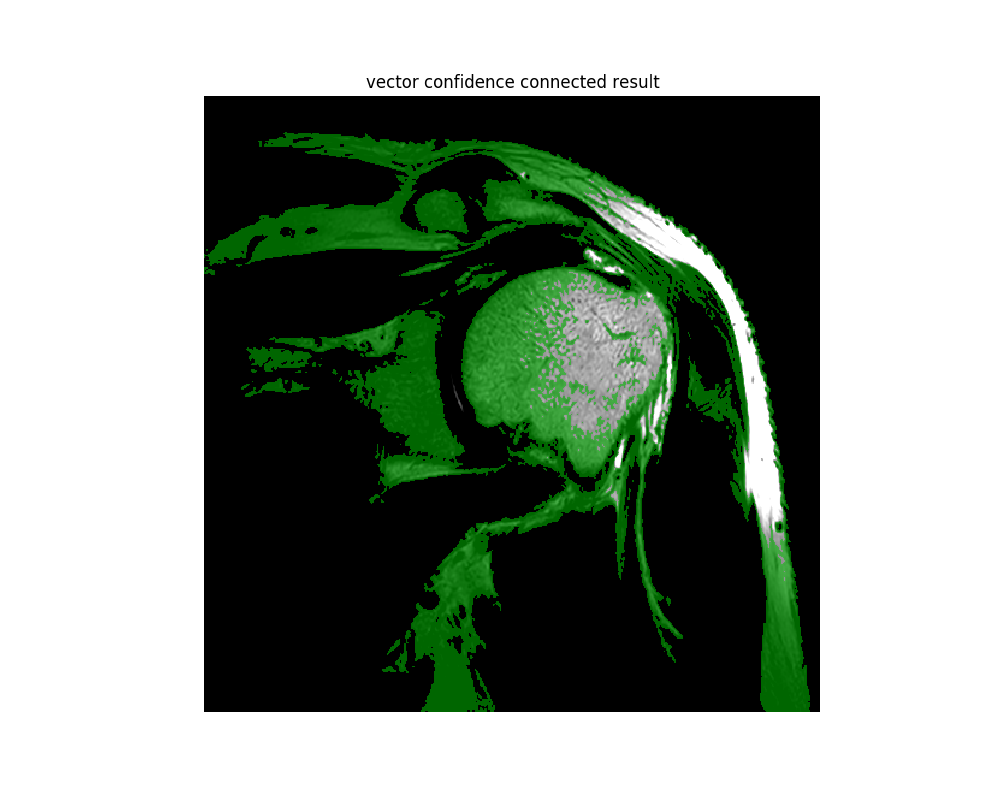

/workspace/1.Imaging/0.Preprocessing/SPIE2018_COURSE-master/gui.py:436: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.imshow(np.squeeze(npa[self.slc]),
/workspace/1.Imaging/0.Preprocessing/SPIE2018_COURSE-master/gui.py:505: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.imshow(np.squeeze(npa[self.slc]),


Box(children=(IntSlider(value=17, description='image slice:', max=34),))

In [33]:
seg_implicit_threshold_vector = sitk.VectorConfidenceConnected(image_multi, 
                                                               initial_seed_point_indexes, 
                                                               numberOfIterations=2, 
                                                               multiplier=4)

gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(image_uint8, seg_implicit_threshold_vector)],                   
                      title_list = ['vector confidence connected result'])

## Clean up, Clean up...

Use of low level segmentation algorithms such as region growing is often followed by a clean up step. In this step we fill holes and remove small connected components. Both of these operations are achieved by using binary morphological operations, opening (BinaryMorphologicalOpening) to remove small connected components and closing (BinaryMorphologicalClosing) to fill holes.

SimpleITK supports several shapes for the structuring elements (kernels) including:
* sitkAnnulus
* sitkBall
* sitkBox
* sitkCross

The size of the kernel can be specified as a scalar (same for all dimensions) or as a vector of values, size per dimension.

The following code cell illustrates the results of such a clean up, using closing to remove holes in the original segmentation.

In [34]:
vectorRadius=(1,1,1)
kernel=sitk.sitkBall
seg_implicit_thresholds_clean = sitk.BinaryMorphologicalClosing(seg_implicit_thresholds, 
                                                                vectorRadius,
                                                                kernel)

And now we compare the original segmentation to the segmentation after clean up (using the GUI you can zoom in on the region of interest for a closer look).

<IPython.core.display.Javascript object>


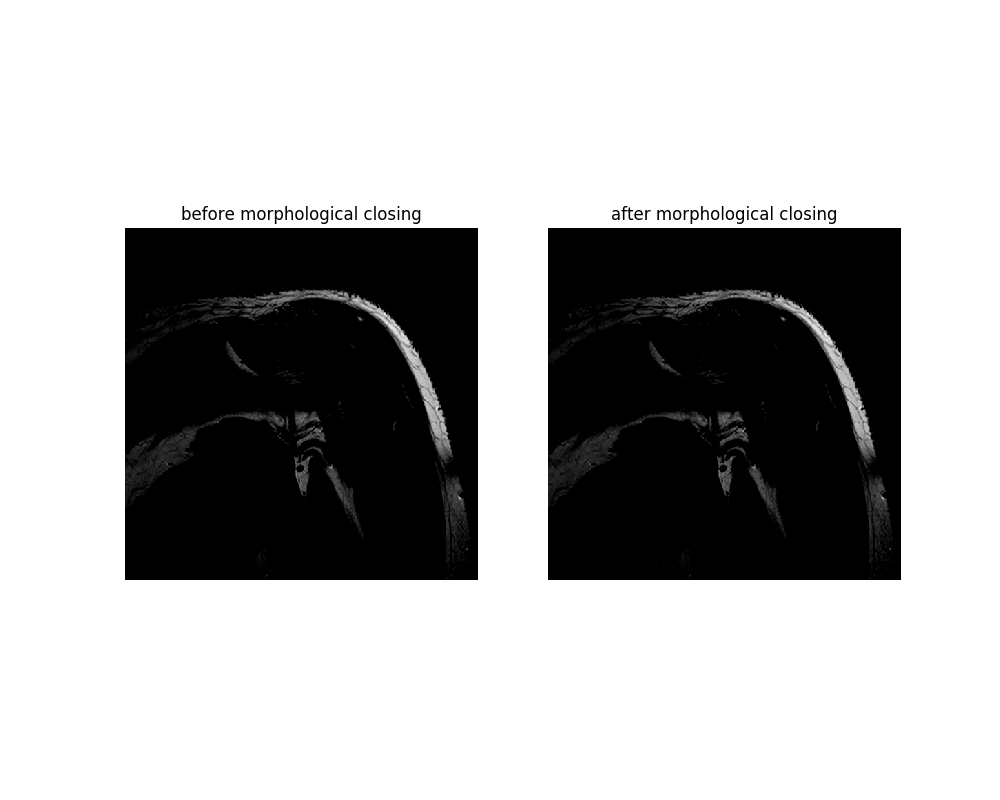

/workspace/1.Imaging/0.Preprocessing/SPIE2018_COURSE-master/gui.py:436: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.imshow(np.squeeze(npa[self.slc]),
/workspace/1.Imaging/0.Preprocessing/SPIE2018_COURSE-master/gui.py:505: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.imshow(np.squeeze(npa[self.slc]),


Box(children=(IntSlider(value=17, description='image slice:', max=34),))

In [36]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(image_uint8, seg_implicit_thresholds),
                                    sitk.LabelOverlay(image_uint8, seg_implicit_thresholds_clean)], 
                      shared_slider=True,
                      title_list = ['before morphological closing', 'after morphological closing'])